In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import *
from scipy.linalg import expm

### Set up functions and parameters 

In [2]:
def gaussian(x):
    b=0
    c=0.155
    MAX=np.exp(-(0-b)**2/(2*c**2))
    
    return np.exp(-(x-b)**2/(2*c**2))/MAX/50

delta1=2
delta2=2
delta3=2
gamma1=4
gamma2=4
gamma3=2
p1=5
p2=5

A=4*p1*gamma1/((p1+gamma1)*(p1+gamma1+gamma3))
T=300

ndetectores=11
xdect_list=np.linspace(-0.6,0.6,ndetectores)

def alpha(d,i):
    return T*gamma3*A*(gaussian(xdect_list[i]-d/2)+gaussian(xdect_list[i]+d/2))

### Load data

In [5]:
Saltos_full=np.load("Saltos_full.npy")
d_full=np.load("d_full.npy")

Saltos_test=np.load("Saltos_train.npy")
d_test=np.load("d_train.npy")

In [6]:
Saltos_valid, Saltos_train=Saltos_full[:8000], Saltos_full[8000:]
d_valid, d_train=d_full[:8000], d_full[8000:]

In [7]:
#Translate test data into a classical signal
Classic_signal=np.zeros([10000,ndetectores],float)

for i in range(0,10000):
    for j in range(0,ndetectores):
        index=np.where(Saltos_test[i,1]==(j+1))
        Classic_signal[i,j]=np.size(index[0])

In [33]:
nsaltos=16

In [38]:
model=keras.models.Sequential()
model.add(keras.Input(shape=(2,nsaltos)))
model.add(keras.layers.LSTM(17, return_sequences=True, activation="selu"))
model.add(keras.layers.LSTM(17, return_sequences=False, activation="selu"))
model.add(keras.layers.Dense(1))

model.compile(loss="mse",
             optimizer="adam",
             metrics=["MeanSquaredError"])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 17)             2312      
                                                                 
 lstm_3 (LSTM)               (None, 17)                2380      
                                                                 
 dense_1 (Dense)             (None, 1)                 18        
                                                                 
Total params: 4,710
Trainable params: 4,710
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history=model.fit(Saltos_train,d_train,epochs=30,
                 validation_data=(Saltos_valid, d_valid))

Epoch 1/30
1313/1313 [==============================] - 6s 3ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0928 - val_mean_squared_error: 0.0928
Epoch 2/30
1313/1313 [==============================] - 4s 3ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 3/30
1313/1313 [==============================] - 4s 3ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 4/30
1313/1313 [==============================] - 3s 3ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 5/30
1313/1313 [==============================] - 3s 3ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0388 - val_mean_squared_error: 0.0388
Epoch 6/30
1313/1313 [==============================] - 4s 3ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 7/30
1313/

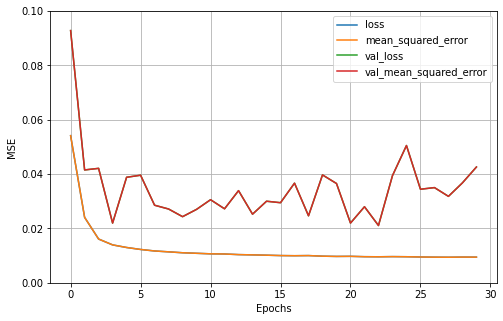

In [40]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
#plt.title("Rendimiento")
plt.ylabel("MSE")
plt.grid(True)
plt.gca().set_ylim(0, 0.1) # set the vertical range to [0-1]
plt.show()

In [25]:
model.save("model_fluoroforo1.h5")

In [8]:
model=keras.models.load_model("model_fluoroforo1.h5")

### Classical signal prediction

In [9]:
nsets=20
nu=500
d_list=np.linspace(0,1,nsets)
L=np.zeros([10000,nsets],float)

#Cálculo del estimador "L"
for k in range(0,10000): #Bucle sobre trayectorias
    for j in range(0,nsets): #Bucle sobre distancias
        Suma1=0
        Suma2=0
        for i in range(0,ndetectores):
            Suma1=Suma1+alpha(d_list[j],i)
            Suma2=Suma2+Classic_signal[k,i]*np.log(alpha(d_list[j],i))
        L[k,j]=Suma2-Suma1    

In [10]:
d_classic=np.zeros(10000,float)

#Sacamos los máximos del estimador
for i in range(0,10000):
    indice=np.argmax(L[i])
    d_classic[i]=d_list[indice]

x=[]
Sigma_classic=[]
for i in range(0,nsets):
    x.append(d_test[i*nu])
    a=d_classic[i*nu:(i+1)*nu]
    
    num_clases=12
    Pi, bins=np.histogram(a, bins=num_clases, density=True)

    diff=bins[1]-bins[0]
    clases=bins[:num_clases]
    clases=clases+diff/2

    d_expect=np.dot(Pi,clases)/np.sum(Pi)
    d_expect2=np.dot(Pi,clases**2)/np.sum(Pi)
    Var=np.abs(d_expect2-2*d_expect*d_test[i*nu]+d_test[i*nu]**2)
    Sigma_classic.append(np.sqrt(Var))

x=np.array(x)
Sigma_classic=np.array(Sigma_classic)  

### Network's prediction

In [11]:
y_proba=model.predict(Saltos_test)

### Finding the MSE with the density histogram

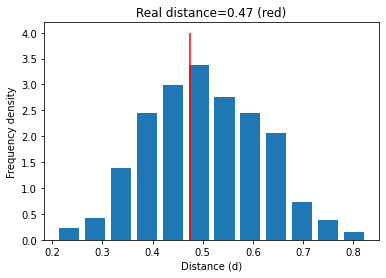

In [54]:
i=9

a=y_proba[i*nu:(i+1)*nu]
    
num_clases=12
hist, bins=np.histogram(a, bins=num_clases, density=True)

diff=bins[1]-bins[0]
clases=bins[:num_clases]
clases=clases+diff/2

plt.bar(clases,hist, width=0.04, align="center")
#plt.plot(clases,hist)
plt.xlabel("Distance (d)")
plt.ylabel("Frequency density")
plt.title("Real distance="+str(round(d_test[i*nu],2))+" (red)")
plt.vlines(d_test[i*nu], 0, 4, 'r')
plt.show()

### Studying dependence with the distance

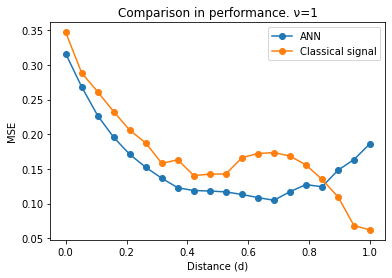

In [12]:
Sigma=[]

for i in range(0,nsets):
    a=y_proba[i*nu:(i+1)*nu]
    
    num_clases=12
    Pi, bins=np.histogram(a, bins=num_clases, density=True)

    diff=bins[1]-bins[0]
    clases=bins[:num_clases]
    clases=clases+diff/2

    d_expect=np.dot(Pi,clases)/np.sum(Pi)
    d_expect2=np.dot(Pi,clases**2)/np.sum(Pi)
    Var=np.abs(d_expect2-2*d_expect*d_test[i*nu]+d_test[i*nu]**2)
    Sigma.append(np.sqrt(Var))

Sigma=np.array(Sigma)

plt.plot(x,Sigma,label="ANN",marker="o")
plt.plot(x,Sigma_classic,label="Classical signal",marker="o")
plt.xlabel("Distance (d)")
plt.ylabel("MSE")
plt.title("Comparison in performance. "+"\u03bd="+str(1))
plt.legend()

plt.show()